In [1]:
def flex_save(path, dpi=400, extensions=['.png','.pdf']):
    for ext in extensions:
        plt.savefig(path+ext, dpi=dpi, bbox_inches='tight')

## Imports & Helpers

In [2]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../../')
from checkmate_imports import *

# global variables 
HUE_ORDER = ['stroma','pred_g2','intermediate_grade','pred_g4']
MIN_SEGMENT_SIZE = 50
GRADE_DIFF_THRESH = 0.35
TUMOR_DIFF_THRESH = 0.35
MIN_TUMOR_SEG_MEAN = 0.70
NODE_DIFF_CUTOFF = invert_rag_weight(GRADE_DIFF_THRESH) 
MIN_TIL_COUNT = 10

# GRADE_TC_CUTOFF = 0.4  # minimum segment mean grade score to consider in TIL processing 
# GRADE_TC_CUTOFF = 0.  # minimum segment mean grade score to consider in TIL processing 
GRADE_TC_CUTOFF = 0.8  # focusing on high grade foci only 

print('MODIFYING EARLIER TIL CUTOFFS')
TIL_ISO_CUTOFF = 14  # based on none vs any AUROC bootstrap on high grade foci + no hard cases
TIL_HIGH_CUTOFF = 48 # based on not-high vs high AUROC bootstrap on high grade foci + no hard cases
FRAC_CUTOFF = 0.25
TIL_AREA_CUTOFF = 10

EXCLUSION_RATIO_CUTOFF = 1.5  # margin vs center ratio threshold for "exclusion" call
TILES_PER_MM2 = 0.256**-2

# assume 7x7 minimum case for a square area focus
# going 2 tiles inner would result in a 5x5 inner cube and thus area cutoff of 25
# MIN_CENTER_AREA = 25
MIN_CENTER_AREA = 10  # relaxing from 25 to try to recover possible interesting foci

MODIFYING EARLIER TIL CUTOFFS


In [3]:
from statannotations.Annotator import Annotator
from statannot import add_stat_annotation
from itertools import combinations, product

In [4]:
# feature_subset = pd.read_csv('../rerun_final_patient_features.csv', index_col=0)
feature_subset = pd.read_csv('/home/jupyter/checkmate-histo/consolidated_workflow/tcga_ricketts_rerun/rerun_final_patient_features_RICKETTS_FILTER.csv', index_col=0)

anno = pd.read_csv('../manual_cm025_merged_braunsupp_annotations.csv') 
anno['unique_id'] = 'cm025_' + anno.subjid.astype(str)
paper_desert = anno.loc[anno.ImmunoPhenotype == 'Desert','unique_id'].values
paper_infl = anno.loc[anno.ImmunoPhenotype == 'Infiltrated','unique_id'].values
paper_excl = anno.loc[anno.ImmunoPhenotype == 'Excluded','unique_id'].values
anno = anno.set_index('unique_id')

node_descriptions = pd.read_csv('../rerun_node_descriptions_with_score_components.csv',index_col=[0])
node_descriptions['merged_labels'] = node_descriptions['merged_labels'].astype(int)

prox_dist_edges = pd.read_csv('../rerun_proximal_and_distal_edge_annotations_with_score_components.csv',index_col=0)

scores = pd.read_csv('../rerun_slidewise_grade_til_scores.csv', index_col=0)

load_tile_info = False

if load_tile_info:
    tilewise_anno = pd.read_csv('../rerun_tilewise_grade_til_annotations.csv', index_col=0) # TIL specific CM025 subset

    edge_info = pd.read_csv('../rerun_base_rag_edge_info_annotation.csv', index_col=[0,1,2,3])
    # restore set objects (stored as string when saved to csv earlier)
    edge_info['edge_set'] = edge_info.reset_index()[['edge0','edge1']].apply(lambda x: set(x),1).values

    # read in non-TIL tilewise info 
    seg_agg = pd.read_csv('../rerun_tilewise_grade_nontil_annotations.csv', index_col=0)
    
    edge_agg_pivot = pd.read_csv('../rerun_base_rag_edge_info_annotation_processed.csv', index_col=[0,1,2])
    edge_class_sum = pd.read_csv('../rerun_base_rag_edge_info_annotation_processed_sum.csv', index_col=0)
    edge_binary = edge_class_sum > 0

### Override previous infiltration cutoffs to simply be based on median 

In [5]:
prev = prepare_cm025_subset(feature_subset, anno=anno, drug_type='any', relabel_edge_cats=True, qbins=2, mandatory_vars=[])

selecting cm025 only
(623, 148)
dropping unusable data (grade seg based)
(569, 148)
dropping entries missing any in ['os', 'os_event']
renaming updated_nonstroma_grade_mean to nonstroma_grade_mean temporarily
(558, 148)
grade quantile bins:  [0.15729222 0.77056246 0.9979857 ]
(558, 149)
dropping low tumor tile count cases
(558, 149)
dropping G1 [keeping unannotated cases]
(557, 149)
dropping metastatic biopsies
(439, 149)
keeping all stages 
(439, 149)
only keeping cases MSKCC risk group annotation
(439, 150)
converting bool edge presence labels to string


In [6]:
prev['all_nodes_area_weighted'].dropna().median()

0.1585503963759909

In [7]:
prev.groupby(['global_infiltration_bin'])['all_nodes_area_weighted'].describe()

,count,mean,std,min,25%,50%,75%,max
global_infiltration_bin,,,,,,,,
high_hg_global_infiltration,176.0,0.370849,0.247098,0.057034,0.157776,0.337544,0.543110,0.969733
low_hg_global_infiltration,87.0,0.017764,0.016090,0.000000,0.004593,0.013818,0.030297,0.055446
no_hg_present,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
MEDIAN_HG_INF_CUTOFF = 0.15855
print(f'Setting Area Infiltration Cutoff to be {MEDIAN_HG_INF_CUTOFF} based on Median')

Setting Area Infiltration Cutoff to be 0.15855 based on Median


In [9]:
crit = (feature_subset['cohort'] == 'cm025') & (feature_subset['usable_til_data']) & (feature_subset['all_nodes_area_weighted'] < MEDIAN_HG_INF_CUTOFF)

In [10]:
feature_subset.loc[crit, 'global_infiltration_bin'] = 'low_hg_global_infiltration'

In [11]:
update = prepare_cm025_subset(feature_subset, anno=anno, drug_type='any', relabel_edge_cats=True, qbins=2, mandatory_vars=[])

selecting cm025 only
(623, 148)
dropping unusable data (grade seg based)
(569, 148)
dropping entries missing any in ['os', 'os_event']
renaming updated_nonstroma_grade_mean to nonstroma_grade_mean temporarily
(558, 148)
grade quantile bins:  [0.15729222 0.77056246 0.9979857 ]
(558, 149)
dropping low tumor tile count cases
(558, 149)
dropping G1 [keeping unannotated cases]
(557, 149)
dropping metastatic biopsies
(439, 149)
keeping all stages 
(439, 149)
only keeping cases MSKCC risk group annotation
(439, 150)
converting bool edge presence labels to string


In [12]:
update.groupby(['global_infiltration_bin'])['all_nodes_area_weighted'].describe()

,count,mean,std,min,25%,50%,75%,max
global_infiltration_bin,,,,,,,,
high_hg_global_infiltration,132.0,0.459134,0.223431,0.15855,0.248671,0.400099,0.619838,0.969733
low_hg_global_infiltration,131.0,0.047398,0.046386,0.00000,0.008805,0.030429,0.087560,0.155452
no_hg_present,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
NONKM_FONT_SCALE = 1.8
KM_FONT_SCALE = 1.2

In [14]:
from statannotations.Annotator import Annotator
from statannot import add_stat_annotation
from itertools import combinations, product

from scipy.stats import mannwhitneyu, fisher_exact, ttest_ind
from lifelines.statistics import pairwise_logrank_test, multivariate_logrank_test, survival_difference_at_fixed_point_in_time_test
from lifelines.statistics import _chisq_test_p_value

In [15]:
def filter_indices(label, index_values):
    return list(filter(lambda x: (label in x[0]) & (label in x[1]), index_values))


def chain_filter_indices(labels, index_values):
    filtered = filter_indices(labels[0], index_values)
    
    for label in labels[1:]:
        filtered = filter_indices(label, filtered)
    return filtered


def test_two_cph(alt_model, null_model):
    ll_null = null_model.log_likelihood_
    ll_alt = alt_model.log_likelihood_

    test_stat = 2 * ll_alt - 2 * ll_null
    print(f'LLR test stat: {test_stat}')
    alt_dim = alt_model.params_.shape[0]
    null_dim = null_model.params_.shape[0]
    assert alt_dim > null_dim  # alt should be more complex in parameter dim
    degrees_freedom = np.abs(alt_dim - null_dim)
    print(f'Using {degrees_freedom} D.F.')
    p_value = _chisq_test_p_value(test_stat, degrees_freedom=degrees_freedom)
    
    return p_value

In [16]:
kirc_pairwise_sweep = pd.read_csv('./[rerun] KIRC sweep [Pairwise logrank].csv', index_col=[0,1])
kirc_pairwise_sweep.index.names = ['a','b']

In [17]:
# scattered_results = {}
# for duration_var in ['os','pfs']:
#     crit = (kirc_pairwise_sweep['col_a']== 'any_diff_edge') & (kirc_pairwise_sweep['col_b']== 'grade_collapsed') 
#     crit = crit & (kirc_pairwise_sweep['duration'] == duration_var)
#     subset = kirc_pairwise_sweep.loc[crit]
#     a = chain_filter_indices(['G2/3'], subset.index.values)
#     b = chain_filter_indices(['G4'], subset.index.values)

#     for x in [a,b]:
#         result_key = f'[fig3c] [pairwise logrank] {x[0][0]} vs. {x[0][1]}'
#         result_pval = subset.loc[x,'p'].item()
#         print(result_key,result_pval)
#         scattered_results[result_key] = result_pval

selecting kirc
(465, 148)
dropping unusable data (grade seg based)
(431, 148)
dropping entries missing any in ['os', 'pfs']
renaming updated_nonstroma_grade_mean to nonstroma_grade_mean temporarily
(429, 148)
grade quantile bins:  [0.0524563  0.33959318 0.58796686 0.95407209]
(429, 149)
dropping low tumor tile count cases
(429, 149)
dropping G1 [keeping unannotated cases]
(419, 149)
dropping metastatic biopsies
(419, 149)
keeping all stages 
(419, 149)
converting bool edge presence labels to string
Running StandardScaler



findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.


LLR test stat: 4.932078530346644
Using 1 D.F.
0.6448938294964786
0.6457479238936192
0.02636259008315076


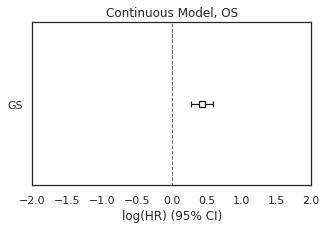

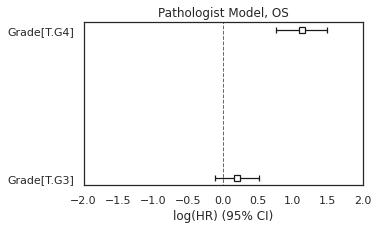

 + MH
LLR test stat: 3.794308397065606
Using 1 D.F.
0.6558393776936823
0.6480868285504047
0.051427114525708084


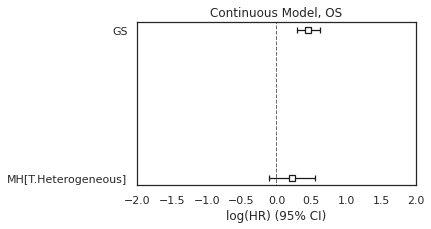

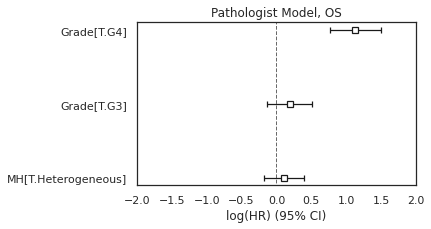


LLR test stat: -17.100314616652895
Using 1 D.F.
0.6897296850913895
0.7186192468619247
1.0


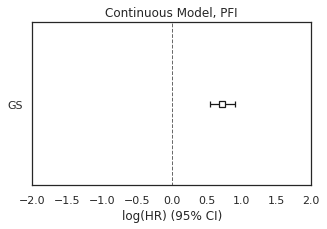

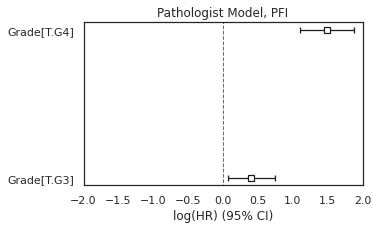

 + MH
LLR test stat: -21.338405400263127
Using 1 D.F.
0.702171878440872
0.7252257212067826
1.0


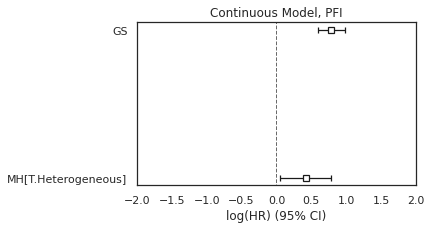

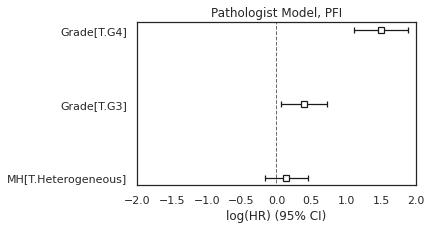

In [18]:
l1_ratio = 0.
penalizer = 0.1
mandatory_vars = ['os','pfs']

dur_map = {'pfs':'PFI', 'os':'OS'}


df = prepare_generic_subset(feature_subset, 'kirc', mandatory_vars=mandatory_vars)
df = df.loc[df['grade'].isin(['G2','G3','G4'])]


df['GS'] = df['nonstroma_grade_mean']
df['MH'] = df['any_diff_edge']
df['Grade'] = df['grade']

df[['GS']] = run_cph_feature_scaling(df, ['GS'])

df['MH'] = df['MH'].map({'Low/Hi Presence':'Heterogeneous', 'No Mixed Foci Presence':'Homogeneous'})
df['MH'] = df['MH'].astype('category')
df['MH'] = df['MH'].cat.reorder_categories(['Homogeneous','Heterogeneous'])

pair_pvals = {}
pvals = {}
for duration_var in ['os','pfs']:
    for mh_term in ['',' + MH']:
        print(mh_term)
        event_var = f'{duration_var}_event'

        cat_model =  CoxPHFitter(l1_ratio=l1_ratio, penalizer=penalizer)
        form = 'Grade' + mh_term
        cat_model.fit(df=df.dropna(subset=mandatory_vars), duration_col=duration_var, event_col=event_var, **{'formula':form})

        cont_model =  CoxPHFitter()
        form = 'GS' + mh_term
        cont_model.fit(df=df.dropna(subset=mandatory_vars), duration_col=duration_var, event_col=event_var, **{'formula':form})
        
        
#         result = test_two_cph(alt_model=cont_model, null_model=cat_model)
        result = test_two_cph(alt_model=cat_model, null_model=cont_model)

        print(cat_model.concordance_index_)
        print(cont_model.concordance_index_)
        print(result)
        set_rc(5,3)
        cont_model.plot()
        plt.xlim(-2,2)
        plt.title(f'Continuous Model, {dur_map[duration_var]}')
        f = f'./supp_figs/remade_prognosis_cindex_gs_with_{mh_term}_kirc_{duration_var}_coef_plot'
        flex_save(f)
    
        plt.show()
        
        cat_model.plot()
        plt.xlim(-2,2)
        plt.title(f'Pathologist Model, {dur_map[duration_var]}')
        f = f'./supp_figs/remade_prognosis_cindex_pathgrade_with_{mh_term}_kirc_{duration_var}_coef_plot'
        flex_save(f)
        
        plt.show()
        pvals[(duration_var, mh_term, 'cat')] = cat_model.concordance_index_
        pvals[(duration_var, mh_term, 'cont')] = cont_model.concordance_index_
        
        pair_pvals[(duration_var, mh_term)] = result

pvals = pd.Series(pvals)
pvals.index.names = ['Survival Type','Formula Term','Grade Type']

pvals.name = 'C-Index'

pvals = pvals.reset_index()

pvals['Formula'] = 'Grade' + pvals['Formula Term']

pvals['Grade Type'] = pvals['Grade Type'].map({'cat':'Pathologist', 'cont':'Continuous'})

pvals['duration'] = pvals['Survival Type']
pvals['Survival Type'] = pvals['Survival Type'].map({'pfs':'PFI', 'os':'OS'})

In [19]:
cont_model.AIC_partial_

1367.390885206205

In [20]:
cat_model.AIC_partial_

1390.729290606468

In [21]:
cat_model.log_likelihood_

-692.364645303234

In [22]:
cont_model.log_likelihood_

-681.6954426031025

In [23]:
2*len(cont_model.params_) - 2*cont_model.log_likelihood_

1367.390885206205

In [24]:
cont_model.AIC_partial_

1367.390885206205

In [25]:
def calculate_approx_rel_likelihood(model_a, model_b):
    """
    Calculate relative likelihood based on CPH model's partial AIC values
    stat = exp(aic_a/2 - aic_b/2)
    """
    aic_1= min(model_a.AIC_partial_, model_b.AIC_partial_)
    aic_2 = max(model_a.AIC_partial_, model_b.AIC_partial_)
    diff = aic_1 - aic_2
    return np.exp(diff/2)

In [26]:
calculate_approx_rel_likelihood(cont_model, cat_model)

8.55322032156661e-06

In [27]:
calculate_approx_rel_likelihood(cat_model, cont_model)

8.55322032156661e-06

selecting kirc
(465, 148)
dropping unusable data (grade seg based)
(431, 148)
dropping entries missing any in ['os', 'pfs']
renaming updated_nonstroma_grade_mean to nonstroma_grade_mean temporarily
(429, 148)
grade quantile bins:  [0.0524563  0.33959318 0.58796686 0.95407209]
(429, 149)
dropping low tumor tile count cases
(429, 149)
dropping G1 [keeping unannotated cases]
(419, 149)
dropping metastatic biopsies
(419, 149)
keeping all stages 
(419, 149)
converting bool edge presence labels to string
Running StandardScaler

Cat model AIC: 1573.8586, C-Index 0.6449


<lifelines.CoxPHFitter: fitted with 417 total observations, 268 right-censored observations>
             duration col = 'os'
                event col = 'os_event'
                penalizer = 0.1
                 l1 ratio = 0.0
      baseline estimation = breslow
   number of observations = 417
number of events observed = 149
   partial log-likelihood = -784.93
         time fit was run = 2022-11-20 23:31:17 UTC

---
              coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                           
Grade[T.G3]   0.20       1.22       0.16            -0.12             0.51                 0.89                 1.67
Grade[T.G4]   1.13       3.08       0.18             0.76             1.49                 2.14                 4.43

               z      p   -log2(p)
covariate                         
Grade[T.G3] 1.23   0.22       2.19
Grade[T.G4] 6.09 <0.005      29.70
---
Concordance = 0.64
Partial AIC = 1573.86
log-likelihood ratio test = 33.84 on 2 df
-log2(p) of ll-ratio test = 24.41

Cont model AIC: 1576.7907, C-Index 0.6457


<lifelines.CoxPHFitter: fitted with 417 total observations, 268 right-censored observations>
             duration col = 'os'
                event col = 'os_event'
      baseline estimation = breslow
   number of observations = 417
number of events observed = 149
   partial log-likelihood = -787.40
         time fit was run = 2022-11-20 23:31:18 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
GS          0.43       1.54       0.08             0.28             0.59                 1.32                 1.81

             z      p   -log2(p)
covariate                       
GS        5.34 <0.005      23.40
---
Concordance = 0.65
Partial AIC = 1576.79
log-likelihood ratio test = 28.91 on 1 df
-log2(p) of ll-ratio test = 23.65

Categorical model has better performance via AIC
Model Relative Likelihood: 0.2308 (prob that weaker model minimizes AIC)


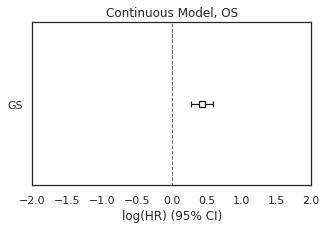

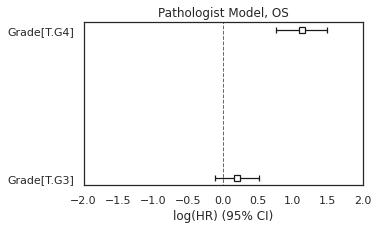

 + MH
Cat model AIC: 1575.3177, C-Index 0.6558


<lifelines.CoxPHFitter: fitted with 417 total observations, 268 right-censored observations>
             duration col = 'os'
                event col = 'os_event'
                penalizer = 0.1
                 l1 ratio = 0.0
      baseline estimation = breslow
   number of observations = 417
number of events observed = 149
   partial log-likelihood = -784.66
         time fit was run = 2022-11-20 23:31:19 UTC

---
                      coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                   
Grade[T.G3]           0.19       1.21       0.16            -0.13             0.51                 0.88                 1.66
Grade[T.G4]           1.13       3.10       0.19             0.77             1.49                 2.16                 4.45
MH[T.Heterogeneous]   0.11       1.11       0.15            -0.18             0.40                 0.83                 1.49

                       z      p   -log2(p)
covariate                                 
Grade[T.G3]         1.16   0.25       2.03
Grade[T.G4]         6.11 <0.005      29.90
MH[T.Heterogeneous] 0.74   0.46       1.12
---
Concordance = 0.66
Partial AIC = 1575.32
log-likelihood ratio test = 34.38 on 3 df
-log2(p) of ll-ratio test = 22.54

Cont model AIC: 1577.1120, C-Index 0.6481


<lifelines.CoxPHFitter: fitted with 417 total observations, 268 right-censored observations>
             duration col = 'os'
                event col = 'os_event'
      baseline estimation = breslow
   number of observations = 417
number of events observed = 149
   partial log-likelihood = -786.56
         time fit was run = 2022-11-20 23:31:19 UTC

---
                      coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                   
GS                    0.46       1.58       0.08             0.29             0.62                 1.34                 1.87
MH[T.Heterogeneous]   0.22       1.25       0.17            -0.11             0.55                 0.89                 1.74

                       z      p   -log2(p)
covariate                                 
GS                  5.39 <0.005      23.76
MH[T.Heterogeneous] 1.30   0.19       2.37
---
Concordance = 0.65
Partial AIC = 1577.11
log-likelihood ratio test = 30.59 on 2 df
-log2(p) of ll-ratio test = 22.07

Categorical model has better performance via AIC
Model Relative Likelihood: 0.4077 (prob that weaker model minimizes AIC)


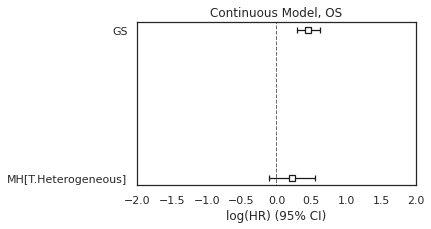

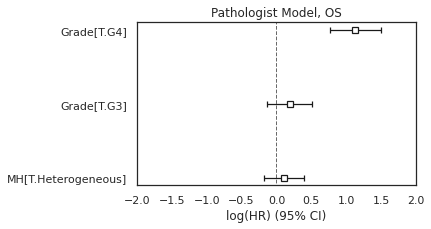


Cat model AIC: 1389.5808, C-Index 0.6897


<lifelines.CoxPHFitter: fitted with 417 total observations, 286 right-censored observations>
             duration col = 'pfs'
                event col = 'pfs_event'
                penalizer = 0.1
                 l1 ratio = 0.0
      baseline estimation = breslow
   number of observations = 417
number of events observed = 131
   partial log-likelihood = -692.79
         time fit was run = 2022-11-20 23:31:21 UTC

---
              coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                           
Grade[T.G3]   0.41       1.50       0.17             0.08             0.74                 1.08                 2.09
Grade[T.G4]   1.49       4.45       0.20             1.11             1.88                 3.02                 6.56

               z      p   -log2(p)
covariate                         
Grade[T.G3] 2.41   0.02       5.96
Grade[T.G4] 7.55 <0.005      44.39
---
Concordance = 0.69
Partial AIC = 1389.58
log-likelihood ratio test = 50.63 on 2 df
-log2(p) of ll-ratio test = 36.52

Cont model AIC: 1370.4805, C-Index 0.7186


<lifelines.CoxPHFitter: fitted with 417 total observations, 286 right-censored observations>
             duration col = 'pfs'
                event col = 'pfs_event'
      baseline estimation = breslow
   number of observations = 417
number of events observed = 131
   partial log-likelihood = -684.24
         time fit was run = 2022-11-20 23:31:21 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
GS          0.73       2.07       0.09             0.55             0.90                 1.73                 2.47

             z      p   -log2(p)
covariate                       
GS        8.02 <0.005      49.80
---
Concordance = 0.72
Partial AIC = 1370.48
log-likelihood ratio test = 67.73 on 1 df
-log2(p) of ll-ratio test = 52.24

Categorical model has worse performance via AIC
Model Relative Likelihood: 0.0001 (prob that weaker model minimizes AIC)


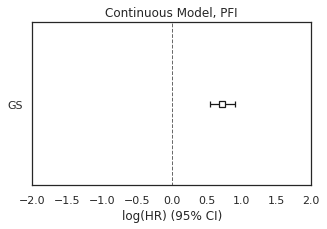

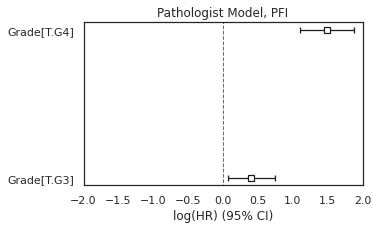

 + MH
Cat model AIC: 1390.7293, C-Index 0.7022


<lifelines.CoxPHFitter: fitted with 417 total observations, 286 right-censored observations>
             duration col = 'pfs'
                event col = 'pfs_event'
                penalizer = 0.1
                 l1 ratio = 0.0
      baseline estimation = breslow
   number of observations = 417
number of events observed = 131
   partial log-likelihood = -692.36
         time fit was run = 2022-11-20 23:31:23 UTC

---
                      coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                   
Grade[T.G3]           0.40       1.48       0.17             0.06             0.73                 1.06                 2.07
Grade[T.G4]           1.50       4.47       0.20             1.11             1.89                 3.03                 6.59
MH[T.Heterogeneous]   0.14       1.15       0.15            -0.16             0.45                 0.85                 1.56

                       z      p   -log2(p)
covariate                                 
Grade[T.G3]         2.33   0.02       5.65
Grade[T.G4]         7.56 <0.005      44.54
MH[T.Heterogeneous] 0.92   0.36       1.49
---
Concordance = 0.70
Partial AIC = 1390.73
log-likelihood ratio test = 51.48 on 3 df
-log2(p) of ll-ratio test = 34.59

Cont model AIC: 1367.3909, C-Index 0.7252


<lifelines.CoxPHFitter: fitted with 417 total observations, 286 right-censored observations>
             duration col = 'pfs'
                event col = 'pfs_event'
      baseline estimation = breslow
   number of observations = 417
number of events observed = 131
   partial log-likelihood = -681.70
         time fit was run = 2022-11-20 23:31:23 UTC

---
                      coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                   
GS                    0.78       2.19       0.10             0.59             0.98                 1.81                 2.66
MH[T.Heterogeneous]   0.42       1.52       0.18             0.06             0.78                 1.06                 2.18

                       z      p   -log2(p)
covariate                                 
GS                  8.02 <0.005      49.74
MH[T.Heterogeneous] 2.27   0.02       5.42
---
Concordance = 0.73
Partial AIC = 1367.39
log-likelihood ratio test = 72.82 on 2 df
-log2(p) of ll-ratio test = 52.53

Categorical model has worse performance via AIC
Model Relative Likelihood: 0.0000 (prob that weaker model minimizes AIC)


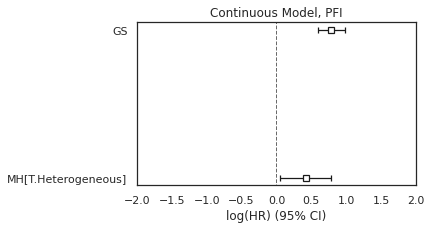

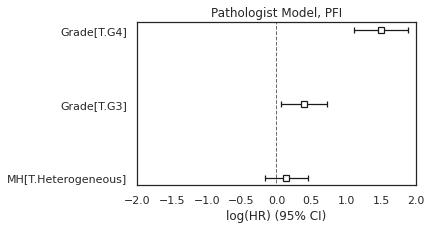

In [28]:
l1_ratio = 0.
penalizer = 0.1
mandatory_vars = ['os','pfs']

dur_map = {'pfs':'PFI', 'os':'OS'}


df = prepare_generic_subset(feature_subset, 'kirc', mandatory_vars=mandatory_vars)
df = df.loc[df['grade'].isin(['G2','G3','G4'])]


df['GS'] = df['nonstroma_grade_mean']
df['MH'] = df['any_diff_edge']
df['Grade'] = df['grade']

df[['GS']] = run_cph_feature_scaling(df, ['GS'])

df['MH'] = df['MH'].map({'Low/Hi Presence':'Heterogeneous', 'No Mixed Foci Presence':'Homogeneous'})
df['MH'] = df['MH'].astype('category')
df['MH'] = df['MH'].cat.reorder_categories(['Homogeneous','Heterogeneous'])

pair_pvals = {}
pvals = {}
for duration_var in ['os','pfs']:
    for mh_term in ['',' + MH']:
        print(mh_term)
        event_var = f'{duration_var}_event'

        cat_model =  CoxPHFitter(l1_ratio=l1_ratio, penalizer=penalizer)
        form = 'Grade' + mh_term
        cat_model.fit(df=df.dropna(subset=mandatory_vars), duration_col=duration_var, event_col=event_var, **{'formula':form})

        cont_model =  CoxPHFitter()
        form = 'GS' + mh_term
        cont_model.fit(df=df.dropna(subset=mandatory_vars), duration_col=duration_var, event_col=event_var, **{'formula':form})
        
        print(f'Cat model AIC: {cat_model.AIC_partial_ :.4f}, C-Index {cat_model.concordance_index_ :.4f}')
        cat_model.print_summary()
        print(f'Cont model AIC: {cont_model.AIC_partial_ :.4f}, C-Index {cont_model.concordance_index_ :.4f}')
        cont_model.print_summary()
        if cat_model.AIC_partial_ > cont_model.AIC_partial_:
            print('Categorical model has worse performance via AIC')
        else:
            print('Categorical model has better performance via AIC')
        
        result = calculate_approx_rel_likelihood(cat_model, cont_model)

        print(f'Model Relative Likelihood: {result :.4f} (prob that weaker model minimizes AIC)')
        set_rc(5,3)
        cont_model.plot()
        plt.xlim(-2,2)
        plt.title(f'Continuous Model, {dur_map[duration_var]}')
        f = f'./supp_figs/remade_prognosis_cindex_gs_with_{mh_term}_kirc_{duration_var}_coef_plot'
        flex_save(f)
    
        plt.show()
        
        cat_model.plot()
        plt.xlim(-2,2)
        plt.title(f'Pathologist Model, {dur_map[duration_var]}')
        f = f'./supp_figs/remade_prognosis_cindex_pathgrade_with_{mh_term}_kirc_{duration_var}_coef_plot'
        flex_save(f)
        
        plt.show()
        pvals[(duration_var, mh_term, 'cat')] = cat_model.concordance_index_
        pvals[(duration_var, mh_term, 'cont')] = cont_model.concordance_index_
        
        pair_pvals[(duration_var, mh_term)] = result

pvals = pd.Series(pvals)
pvals.index.names = ['Survival Type','Formula Term','Grade Type']

pvals.name = 'C-Index'

pvals = pvals.reset_index()

pvals['Formula'] = 'Grade' + pvals['Formula Term']

pvals['Grade Type'] = pvals['Grade Type'].map({'cat':'Pathologist', 'cont':'Continuous'})

pvals['duration'] = pvals['Survival Type']
pvals['Survival Type'] = pvals['Survival Type'].map({'pfs':'PFI', 'os':'OS'})

In [29]:
pair_pvals

{('os', ''): 0.23083796491569358,
 ('os', ' + MH'): 0.4077283241572933,
 ('pfs', ''): 7.11900633962926e-05,
 ('pfs', ' + MH'): 8.55322032156661e-06}

In [30]:
# set_rc(10,10,1.6)
# sns.catplot(kind='bar', col='Survival Type', hue='Grade Type', y='C-Index', x='Formula', data=pvals.loc[pvals['Survival Type'] == 'PFI'].reset_index())
# plt.ylim(0.6,0.75)

In [31]:
# set_rc(10,10,1.6)
# sns.catplot(kind='bar', col='Survival Type', hue='Grade Type', y='C-Index', x='Formula', data=pvals.loc[pvals['Survival Type'] == 'OS'].reset_index())
# plt.ylim(0.6,0.75)

findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Grade + MH_Pathologist vs. Grade + MH_Continuous: Custom statistical test, P_val:4.077e-01
Grade_Pathologist vs. Grade_Continuous: Custom statistical test, P_val:2.308e-01


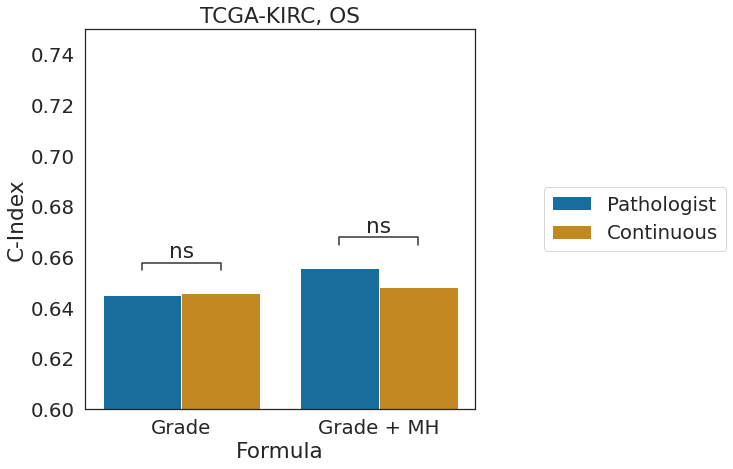

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Grade + MH_Pathologist vs. Grade + MH_Continuous: Custom statistical test, P_val:8.553e-06
Grade_Pathologist vs. Grade_Continuous: Custom statistical test, P_val:7.119e-05


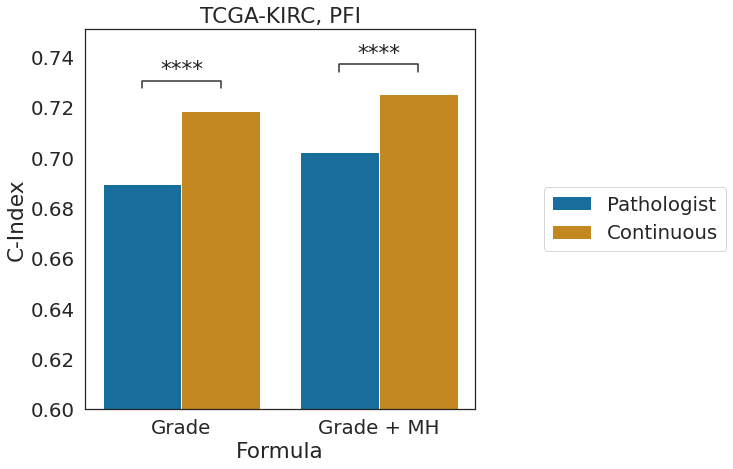

In [32]:
for duration_var in ['os','pfs']:
    set_rc(7,7, 1.8, palette='colorblind')
    plot_kws = {
        'x':'Formula',
        'y':'C-Index',
        'hue':'Grade Type',
        'data':pvals.loc[pvals['duration'] == duration_var].reset_index(),
    }

    g = sns.barplot(**plot_kws)
    move_leg(g, x=1.15)
    plt.ylim(0.6, 0.75)
    pairs = [
        (('Grade','Pathologist'), ('Grade','Continuous')),
        (('Grade + MH','Pathologist'), ('Grade + MH','Continuous'))
            ]
    plot_pvals = [
        pair_pvals[(duration_var, '')],
        pair_pvals[(duration_var, ' + MH')],
    ]
    plt.title(f'TCGA-KIRC, {dur_map[duration_var]}')
    annotator = Annotator(g, pairs, **plot_kws)
    annotator.set_pvalues(plot_pvals)
    annotator.annotate()
    
    f = f'./main_figs/remade_prognosis_cindex_grade_comparison_kirc_{duration_var}'
    flex_save(f)
    plt.show()

### Calculate pairwise relative likelihoods 

In [33]:
meta_store = {}
meta_pvals = {}

for duration_var in ['os','pfs']:
    model_store = {}
    pval_remake = {}
    
    for mh_term in ['',' + MH']:
        print(mh_term)
        event_var = f'{duration_var}_event'

        cat_model =  CoxPHFitter(l1_ratio=l1_ratio, penalizer=penalizer)
        form = 'Grade' + mh_term
        cat_model.fit(df=df.dropna(subset=mandatory_vars), duration_col=duration_var, event_col=event_var, **{'formula':form})

        cont_model =  CoxPHFitter()
        form = 'GS' + mh_term
        cont_model.fit(df=df.dropna(subset=mandatory_vars), duration_col=duration_var, event_col=event_var, **{'formula':form})
        
#         print(f'Cat model AIC: {cat_model.AIC_partial_ :.2f}, C-Index {cat_model.concordance_index_ :.2f}')
# #         cat_model.print_summary()
#         print(f'Cont model AIC: {cont_model.AIC_partial_ :.2f}, C-Index {cont_model.concordance_index_ :.2f}')
# #         cont_model.print_summary()
#         if cat_model.AIC_partial_ > cont_model.AIC_partial_:
#             print('Categorical model has worse performance via AIC')
#         else:
#             print('Categorical model has better performance via AIC')
        
        if mh_term == '':
            form = 'Base'
        else:
            form = 'Base + MH'
            
        model_store[(duration_var, form, 'cat')] = cat_model
        model_store[(duration_var, form, 'cont')] = cont_model
        
        for a, b in list(combinations(model_store.keys(),2)):
            model_a = model_store[a]
            model_b = model_store[b]

            result = calculate_approx_rel_likelihood(model_a, model_b)
            pval_remake[(a[1:],b[1:])] = result
            

    
    meta_store[duration_var] = model_store
    meta_pvals[duration_var] = pval_remake
#         result = calculate_approx_rel_likelihood(cat_model, cont_model)


 + MH

 + MH


In [34]:
a[1:]

('Base + MH', 'cat')

In [35]:
model_store.keys()

dict_keys([('pfs', 'Base', 'cat'), ('pfs', 'Base', 'cont'), ('pfs', 'Base + MH', 'cat'), ('pfs', 'Base + MH', 'cont')])

In [36]:
pval_remake

{(('Base', 'cat'), ('Base', 'cont')): 7.11900633962926e-05,
 (('Base', 'cat'), ('Base + MH', 'cat')): 0.5631328979453095,
 (('Base', 'cat'), ('Base + MH', 'cont')): 1.5188635493991834e-05,
 (('Base', 'cont'), ('Base + MH', 'cat')): 4.008946670526455e-05,
 (('Base', 'cont'), ('Base + MH', 'cont')): 0.2133533076019542,
 (('Base + MH', 'cat'), ('Base + MH', 'cont')): 8.55322032156661e-06}

In [37]:
def make_statannotations_pairs(i, j, mode='inner'):
    if mode == 'inner':
        pairs = []
        for x in i:
            pairs.extend(list(combinations(product([x],j), 2)))
            
    if mode == 'full':
         pairs = list(combinations(product(i,j),2))
            
    return pairs
	

In [38]:
list(pval_remake.keys())[0]

(('Base', 'cat'), ('Base', 'cont'))

In [39]:
def filter_pairs_outer(pairs):
    return [(a,b) for  a, b in pairs if (a[1] == b[1])]

def filter_pairs_inner(pairs):
    return [(a,b) for  a, b in pairs if (a[0] == b[0])]      

In [40]:
for duration_var in ['os','pfs']:
    print('\n', duration_var)
    pval_remake = meta_pvals[duration_var]
    print('Non-visualizezd')
    print('Outer')
    for a, b in filter_pairs_outer(list(pval_remake.keys())):
        print(a, b, pval_remake[(a,b)])
        
    print('Inner')
    for a, b in filter_pairs_inner(list(pval_remake.keys())):
        print(a, b, pval_remake[(a,b)])


 os
Non-visualizezd
Outer
('Base', 'cat') ('Base + MH', 'cat') 0.4821304920969713
('Base', 'cont') ('Base + MH', 'cont') 0.8515854731245069
Inner
('Base', 'cat') ('Base', 'cont') 0.23083796491569358
('Base + MH', 'cat') ('Base + MH', 'cont') 0.4077283241572933

 pfs
Non-visualizezd
Outer
('Base', 'cat') ('Base + MH', 'cat') 0.5631328979453095
('Base', 'cont') ('Base + MH', 'cont') 0.2133533076019542
Inner
('Base', 'cat') ('Base', 'cont') 7.11900633962926e-05
('Base + MH', 'cat') ('Base + MH', 'cont') 8.55322032156661e-06


### Univariate within grade bins

In [41]:
for g in ['quantile_bin_0','quantile_bin_1','quantile_bin_2']:
    subset = df.loc[df['quantile_bin'] == g]
    cont_model =  CoxPHFitter(l1_ratio=l1_ratio, penalizer=penalizer)
    form = 'MH'
    cont_model.fit(df=subset.dropna(subset=mandatory_vars), duration_col=duration_var, event_col=event_var, **{'formula':form})
    print(g)
    cont_model.print_summary()

quantile_bin_0


<lifelines.CoxPHFitter: fitted with 134 total observations, 120 right-censored observations>
             duration col = 'pfs'
                event col = 'pfs_event'
                penalizer = 0.1
                 l1 ratio = 0.0
      baseline estimation = breslow
   number of observations = 134
number of events observed = 14
   partial log-likelihood = -59.61
         time fit was run = 2022-11-20 23:31:30 UTC

---
                      coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                   
MH[T.Heterogeneous]   0.36       1.43       0.40            -0.42             1.13                 0.66                 3.10

                       z    p   -log2(p)
covariate                               
MH[T.Heterogeneous] 0.90 0.37       1.44
---
Concordance = 0.55
Partial AIC = 121.22
log-likelihood ratio test = 0.80 on 1 df
-log2(p) of ll-ratio test = 1.43

quantile_bin_1


<lifelines.CoxPHFitter: fitted with 141 total observations, 99 right-censored observations>
             duration col = 'pfs'
                event col = 'pfs_event'
                penalizer = 0.1
                 l1 ratio = 0.0
      baseline estimation = breslow
   number of observations = 141
number of events observed = 42
   partial log-likelihood = -178.98
         time fit was run = 2022-11-20 23:31:31 UTC

---
                      coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                   
MH[T.Heterogeneous]   0.30       1.35       0.28            -0.24             0.85                 0.79                 2.33

                       z    p   -log2(p)
covariate                               
MH[T.Heterogeneous] 1.09 0.27       1.87
---
Concordance = 0.58
Partial AIC = 359.96
log-likelihood ratio test = 1.22 on 1 df
-log2(p) of ll-ratio test = 1.89

quantile_bin_2


<lifelines.CoxPHFitter: fitted with 142 total observations, 67 right-censored observations>
             duration col = 'pfs'
                event col = 'pfs_event'
                penalizer = 0.1
                 l1 ratio = 0.0
      baseline estimation = breslow
   number of observations = 142
number of events observed = 75
   partial log-likelihood = -326.58
         time fit was run = 2022-11-20 23:31:31 UTC

---
                      coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                   
MH[T.Heterogeneous]   0.06       1.06       0.23            -0.39             0.50                 0.68                 1.65

                       z    p   -log2(p)
covariate                               
MH[T.Heterogeneous] 0.25 0.80       0.32
---
Concordance = 0.51
Partial AIC = 655.16
log-likelihood ratio test = 0.06 on 1 df
-log2(p) of ll-ratio test = 0.32

In [42]:
for g in ['G2','G3','G4']:
    subset = df.loc[df['grade'] == g]
    cat_model =  CoxPHFitter(l1_ratio=l1_ratio, penalizer=penalizer)
    form = 'MH'
    cat_model.fit(df=subset.dropna(subset=mandatory_vars), duration_col=duration_var, event_col=event_var, **{'formula':form})
    print(g)
    cat_model.print_summary()

G2


<lifelines.CoxPHFitter: fitted with 186 total observations, 156 right-censored observations>
             duration col = 'pfs'
                event col = 'pfs_event'
                penalizer = 0.1
                 l1 ratio = 0.0
      baseline estimation = breslow
   number of observations = 186
number of events observed = 30
   partial log-likelihood = -141.28
         time fit was run = 2022-11-20 23:31:32 UTC

---
                      coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                   
MH[T.Heterogeneous]   0.06       1.07       0.30            -0.52             0.64                 0.60                 1.90

                       z    p   -log2(p)
covariate                               
MH[T.Heterogeneous] 0.22 0.83       0.27
---
Concordance = 0.52
Partial AIC = 284.57
log-likelihood ratio test = 0.05 on 1 df
-log2(p) of ll-ratio test = 0.27

G3


<lifelines.CoxPHFitter: fitted with 170 total observations, 112 right-censored observations>
             duration col = 'pfs'
                event col = 'pfs_event'
                penalizer = 0.1
                 l1 ratio = 0.0
      baseline estimation = breslow
   number of observations = 170
number of events observed = 58
   partial log-likelihood = -262.93
         time fit was run = 2022-11-20 23:31:32 UTC

---
                      coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                   
MH[T.Heterogeneous]   0.31       1.36       0.23            -0.15             0.77                 0.86                 2.16

                       z    p   -log2(p)
covariate                               
MH[T.Heterogeneous] 1.33 0.18       2.44
---
Concordance = 0.56
Partial AIC = 527.86
log-likelihood ratio test = 1.78 on 1 df
-log2(p) of ll-ratio test = 2.45

G4


<lifelines.CoxPHFitter: fitted with 61 total observations, 18 right-censored observations>
             duration col = 'pfs'
                event col = 'pfs_event'
                penalizer = 0.1
                 l1 ratio = 0.0
      baseline estimation = breslow
   number of observations = 61
number of events observed = 43
   partial log-likelihood = -142.95
         time fit was run = 2022-11-20 23:31:32 UTC

---
                      coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                   
MH[T.Heterogeneous]  -0.17       0.85       0.31            -0.77             0.43                 0.47                 1.54

                        z    p   -log2(p)
covariate                                
MH[T.Heterogeneous] -0.55 0.58       0.77
---
Concordance = 0.53
Partial AIC = 287.91
log-likelihood ratio test = 0.30 on 1 df
-log2(p) of ll-ratio test = 0.78

In [43]:
cat_model.summary

,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,z,p,-log2(p)
covariate,,,,,,,,,,
MH[T.Heterogeneous],-0.166982,0.846215,0.305409,-0.765573,0.431609,0.465068,1.539732,-0.546749,0.584551,0.774599
